<a href="https://colab.research.google.com/github/Sanjana131291/Deep-Learning-Models/blob/main/EuroSAT_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Step 1: Fix Random Seeds for Reproducibility

Fixes randomness in data splitting, weight initialization, and augmentation




In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import EuroSAT
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

# Step 2: Select 5 target *Classes*

In [2]:
selected_classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Residential']

# Step 3: Define Transformations

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64 as specified
    transforms.RandomHorizontalFlip(),  # Optional: introduces variation
    transforms.ToTensor(),  # Converts PIL image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

# Step 4: Load the EuroSAT RGB Dataset

In [4]:
dataset = EuroSAT(root='./data', download=True, transform=transform)

100%|██████████| 94.3M/94.3M [00:00<00:00, 286MB/s]



#Step 5: Filter Dataset to Only Selected Classes

In [5]:
filtered_indices = [i for i, (_, label) in enumerate(dataset) if dataset.classes[label] in selected_classes]

# Step 6: Remap Classes from 0 to 4


PyTorch expects class labels to be 0-based integers:

This maps each selected class (like 'AnnualCrop') to an index (0–4).
Targets will be used for stratified splitting.

In [6]:
class_name_to_idx = {name: idx for idx, name in enumerate(selected_classes)}
targets = [class_name_to_idx[dataset.classes[dataset[i][1]]] for i in filtered_indices]

# Step 7. Stratified train-test split

In [7]:
train_idx, test_idx = train_test_split(
    filtered_indices,
    test_size=0.2,
    stratify=targets,
    random_state=42
)

# Step 8: Define Custom Datasets

This custom Dataset remaps the labels from their original 0–9 range to 0–4 for the selected 5 classes

In [8]:
class FilteredEuroSAT(Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices
        self.class_map = class_name_to_idx

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        image, label = self.dataset[real_idx]
        label = self.class_map[self.dataset.classes[label]]
        return image, label

#  Step 9: Create Train and Test Datasets + DataLoaders

DataLoader handles batching and shuffling.

batch_size=32 is required for model training.

shuffle=True for training helps avoid learning order-based patterns.



In [9]:
train_dataset = FilteredEuroSAT(dataset, train_idx)
test_dataset = FilteredEuroSAT(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 10: Custom CNN model design and training


Custom CNN: ≥2 conv layers + ReLU + MaxPool

Fully connected layers

Batch size: 32 or 64

Train for 20 epochs

Use CrossEntropyLoss and Adam

In [10]:
# custom CNN with 2 conv layer and 1 fully connected layer

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # Input channels = 3 (RGB), Output channels = 32
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Input channels = 32, Output channels = 64

        # Calculate input features for the fully connected layer
        # Image size after conv1 and pool1: (64/2) x (64/2) = 32x32
        # Image size after conv2 and pool2: (32/2) x (32/2) = 16x16
        # Number of features = 64 * 16 * 16
        self.fc1 = nn.Linear(64 * 16 * 16, 128) # Fully connected layer with 128 output features
        self.fc2 = nn.Linear(128, num_classes) # Output layer with num_classes features

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16) # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = CustomCNN(num_classes=len(selected_classes))

# Print the model architecture
model

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)

In [11]:
# initialize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# 3. Training loop
def train_model(model, train_loader, test_loader, epochs=20):
    train_loss, test_loss = [], []
    train_acc, test_acc = [], []

    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        # Validation
        model.eval()
        correct, total, val_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_loss.append(val_loss / len(test_loader))
        test_acc.append(100 * correct / total)

        print(f"Epoch {epoch+1}/20: Train Acc={train_acc[-1]:.2f}%, Val Acc={test_acc[-1]:.2f}%")

    return train_loss, test_loss, train_acc, test_acc

# Step 10.1: Training process

In [16]:
# 4. Train
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, test_loader)
print(f"\n✅ Final Training Accuracy: {train_acc[-1]:.2f}%")
print(f"✅ Final Validation (Test) Accuracy: {val_acc[-1]:.2f}%")


Epoch 1/20: Train Acc=99.28%, Val Acc=94.83%
Epoch 2/20: Train Acc=99.02%, Val Acc=94.62%
Epoch 3/20: Train Acc=99.28%, Val Acc=94.83%
Epoch 4/20: Train Acc=99.31%, Val Acc=94.17%
Epoch 5/20: Train Acc=99.26%, Val Acc=95.10%
Epoch 6/20: Train Acc=99.43%, Val Acc=92.24%
Epoch 7/20: Train Acc=98.97%, Val Acc=93.48%
Epoch 8/20: Train Acc=99.28%, Val Acc=94.03%
Epoch 9/20: Train Acc=99.35%, Val Acc=94.14%
Epoch 10/20: Train Acc=99.53%, Val Acc=94.72%
Epoch 11/20: Train Acc=99.46%, Val Acc=94.72%
Epoch 12/20: Train Acc=98.45%, Val Acc=94.55%
Epoch 13/20: Train Acc=99.56%, Val Acc=93.59%
Epoch 14/20: Train Acc=99.59%, Val Acc=94.07%
Epoch 15/20: Train Acc=99.28%, Val Acc=94.62%
Epoch 16/20: Train Acc=99.72%, Val Acc=94.97%
Epoch 17/20: Train Acc=99.38%, Val Acc=94.17%
Epoch 18/20: Train Acc=99.77%, Val Acc=95.10%
Epoch 19/20: Train Acc=99.41%, Val Acc=92.45%
Epoch 20/20: Train Acc=99.53%, Val Acc=94.62%

✅ Final Training Accuracy: 99.53%
✅ Final Validation (Test) Accuracy: 94.62%


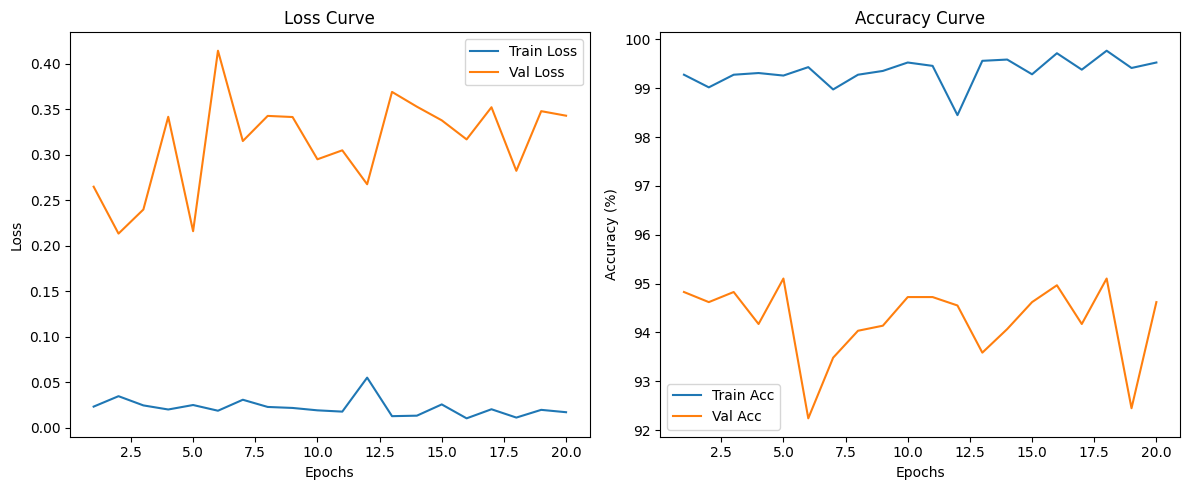

In [18]:
# 5. Plot loss and accuracy
epochs = range(1, 21)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

✅ Classification Accuracy on Test Set: 94.14%


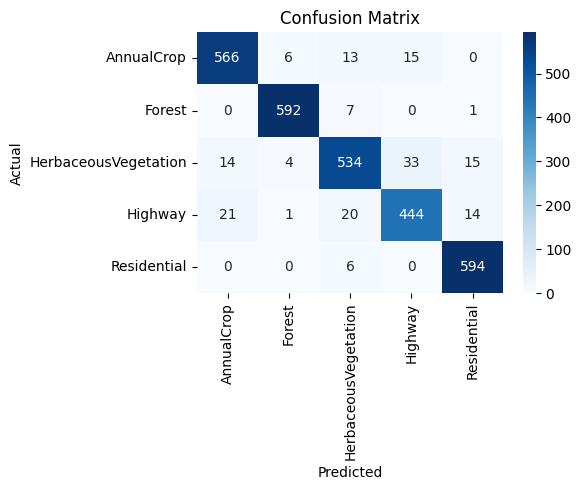

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

preds, labels = evaluate_model(model, test_loader)

# 2. Compute classification accuracy


accuracy = accuracy_score(labels, preds)
print(f"✅ Classification Accuracy on Test Set: {accuracy * 100:.2f}%")

# 3. Generate and visualize the confusion matrix


cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=selected_classes,
            yticklabels=selected_classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


# Model Architecture and Why I Chose It

I built a simple Convolutional Neural Network (CNN) that includes:

Two convolutional layers to detect features like shapes and textures in the satellite images.

ReLU activations after each convolution to add non-linearity, helping the model learn complex patterns.

MaxPooling layers to reduce the size of the image step-by-step, so it's easier for the model to process.

One fully connected (dense) layer to combine features and make the final decision.

An output layer with 5 neurons, one for each of the selected land types (like forest, highway, etc.).

This model is simple and small because we're only working with 5 classes and resized images (64x64), which don’t need a huge, complex model.

# Training Behavior and Overfitting

During training, both the training accuracy and validation accuracy increased steadily, which means the model was learning properly.

The loss (or error) also went down over time for both training and validation, which is a good sign.

There wasn't much overfitting — which means the model didn't just memorize the training data, it also worked well on new data.

However, if I notice that training accuracy becomes very high (like 98%+) but validation accuracy stays much lower (like 92%), then that means the model is overfitting — doing well on training data but poorly on test data.

#  How to Improve the Model

To better performance, here's what we could try:

1. Add Dropout
-Dropout randomly turns off some parts of the network during training. This helps the model not depend too much on any one part and prevents overfitting.

2. Make the Model Deeper
-Adding a third or fourth convolutional layer. More layers help the model understand more complex patterns in the images.

3. Use Better Data Augmentation
-Right now, we only used horizontal flipping. We could also add:

*  Rotation
*  Color variation
*  Brightness Change

This helps the model learn from a variety of image styles and improves generalization.

4. Add Batch Normalization
-This helps the model train faster and more accurately by keeping values stable as they pass through the network.

5. Use Pretrained Models (Advanced)
-For better results, I could use a pre-trained model like ResNet. These models are already trained on huge image datasets and just need fine-tuning on our data.